# Performance Skyline
The perfomance skyline of a trace contains only the events in the dominant path.

More info in [Performance Skyline: Inferring Process Performance Models from Interval Events Paper](https://www.springerprofessional.de/en/performance-skyline-inferring-process-performance-models-from-in/19021296)

In [1]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import importlib

In [2]:
print(os.getcwd())
import sys
sys.path.append(os.getcwd()+'/../perfSky')
#sys.path.append('/Users/andreamaldonado/git_tree/perfSky/perfSky')

from Skyline import get_relative_timestamps, get_skyline_points, get_average_trace, get_skyline_activity_set
import Visualizer as pt

/Users/andreamaldonado/git_tree/perfSky/notebooks


In [3]:
ACTIVITY_ID='common_act'

#df = pd.read_csv("../data/daily.2019-July_September.csv")
df = pd.read_csv("../data/clustered_agg_edit_75_daily.csv", sep=";")
#df = df[['case', 'activity', 'start_time', 'end_time','cluster_id']]
#df['start_time']=df['start_time'].apply(lambda x: x.split('+')[0])
#df['end_time']=df['end_time'].apply(lambda x: x.split('+')[0])
df['activity_original'] = df['activity']
df['activity']=df[ACTIVITY_ID]
df.head()

excluding = get_relative_timestamps(df, ['AllTasks']) #'AllTasks' is one entry per log with its overall duration


print('Data set contains:')
print('- ',len(excluding),'events')
print('- ',len(excluding['case'].unique()),'cases')
print('- ',len(excluding['activity'].unique()),'activities')
#print('- ',len(excluding['cluster_id'].unique()),' clustered activities')

sample = excluding[excluding['case'].isin(excluding['case'].unique()[:5])]
excluding.head()

Grouped: 61864 columns ['case', 'activity', 'start_time', 'end_time', 'cluster_id', 'common_act', 'activity_original', 'zero_point']
Merged relatived: 61930 columns ['case', 'activity', 'start_time', 'end_time', 'cluster_id_x', 'common_act_x', 'activity_original_x', 'zero_point', 'cluster_id_y', 'common_act_y', 'activity_original_y']
Data set contains:
-  61930 events
-  50 cases
-  75 activities


case  \
221  daily.2019-07-01_10-28-01   
222  daily.2019-07-01_10-28-01   
223  daily.2019-07-01_10-28-01   
224  daily.2019-07-01_10-28-01   
225  daily.2019-07-01_10-28-01   

                                              activity rel_start  rel_end  \
221                          DumpTask(sql_filename=_11   0:00:00  0:04:52   
222  DumpTask(sql_filename=reprocess_urls)(kvs=None...   0:00:00  0:01:43   
223                          DumpTask(sql_filename=_11   0:00:00  1:02:58   
224                                  ProxySetupTask_16   0:00:00  0:13:17   
225                                   CrawlFeedTask_61   0:00:00  0:17:10   

     num_start  num_end           start_time             end_time  
221        0.0    292.0  2019-07-01 10:41:26  2019-07-01 10:46:18  
222        0.0    103.0  2019-07-01 10:41:26  2019-07-01 10:43:09  
223        0.0   3778.0  2019-07-01 10:41:26  2019-07-01 11:44:24  
224        0.0    797.0  2019-07-01 10:41:26  2019-07-01 10:54:43  
225        0.0   1030.0  2019-07-01 10:41:26  2019-07-01 10:58:36

In [4]:
excluding = get_relative_timestamps(sample, ['AllTasks']) #'AllTasks' is one entry per log with its overall duration

print('Data set contains:')
print('- ',len(excluding),'events')
print('- ',len(excluding['case'].unique()),'cases')
print('- ',len(excluding['activity'].unique()),'activities')

excluding.head()

Grouped: 6241 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 6265 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
Data set contains:
-  6265 events
-  5 cases
-  70 activities


case  \
0   daily.2019-07-01_10-28-01   
21  daily.2019-07-01_10-28-01   
22  daily.2019-07-01_10-28-01   
23  daily.2019-07-01_10-28-01   
24  daily.2019-07-01_10-28-01   

                                             activity rel_start  rel_end  \
0                           DumpTask(sql_filename=_11   0:00:00  0:04:52   
21                                   CrawlFeedTask_61   0:00:00  0:17:10   
22                                  ProxySetupTask_16   0:00:00  0:13:17   
23                          DumpTask(sql_filename=_11   0:00:00  1:02:58   
24  DumpTask(sql_filename=reprocess_urls)(kvs=None...   0:00:00  0:01:43   

    num_start  num_end           start_time             end_time  
0         0.0    292.0  2019-07-01 10:41:26  2019-07-01 10:46:18  
21        0.0   1030.0  2019-07-01 10:41:26  2019-07-01 10:58:36  
22        0.0    797.0  2019-07-01 10:41:26  2019-07-01 10:54:43  
23        0.0   3778.0  2019-07-01 10:41:26  2019-07-01 11:44:24  
24        0.0    103.0  2019-07-01 10:41:26  2019-07-01 10:43:09

In [12]:
vis = pt.Vis()

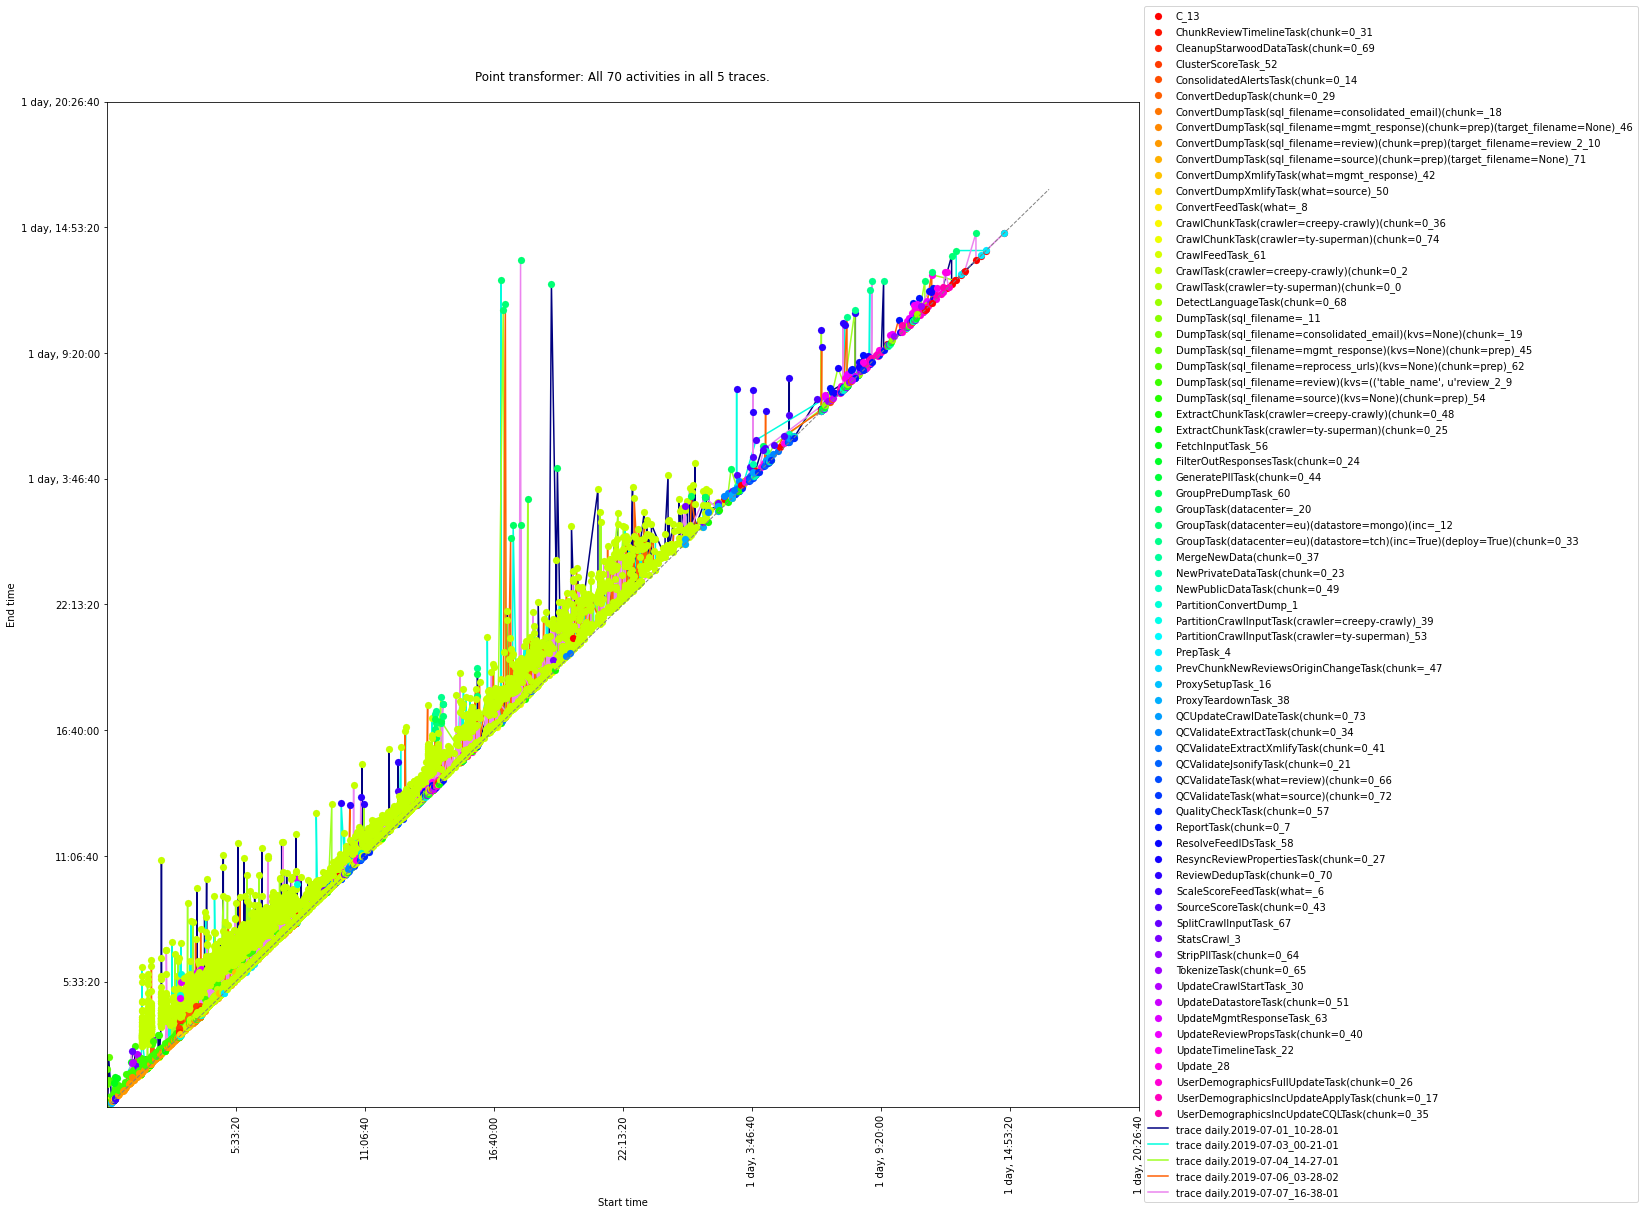

In [10]:
vis.plot_all_traces(sample, show_plot=None)

<AxesSubplot:ylabel='Frequency'>

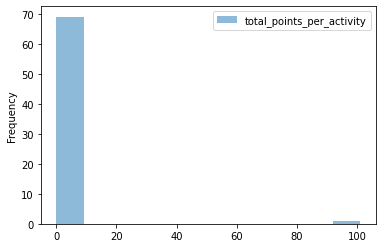

In [5]:
all_by_activity = excluding.groupby('activity').size().reset_index(name='total_points_per_activity').sort_values(by=['total_points_per_activity'], ascending=False)
all_by_activity['total_points_per_activity']=all_by_activity.apply(lambda row: round(row['total_points_per_activity']/50), axis=1)
all_by_activity.plot.hist(bins=11, alpha=0.5)

Frequency of activities having more than 1 event per activity  3 

                                             activity  \
17         CrawlTask(crawler=creepy-crawly)(chunk=0_2   
25  DumpTask(sql_filename=review)(kvs=(('table_nam...   
8   ConvertDumpTask(sql_filename=review)(chunk=pre...   

    total_points_per_activity  
17                        101  
25                          4  
8                           4  


<AxesSubplot:ylabel='Frequency'>

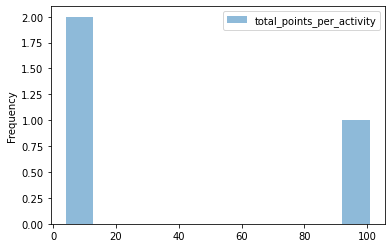

In [6]:
print('Frequency of activities having more than 1 event per activity ',len(all_by_activity[all_by_activity['total_points_per_activity']>1]), '\n')
print(all_by_activity[all_by_activity['total_points_per_activity']>1])
all_by_activity[all_by_activity['total_points_per_activity']>1].plot.hist(bins=11, alpha=0.5)

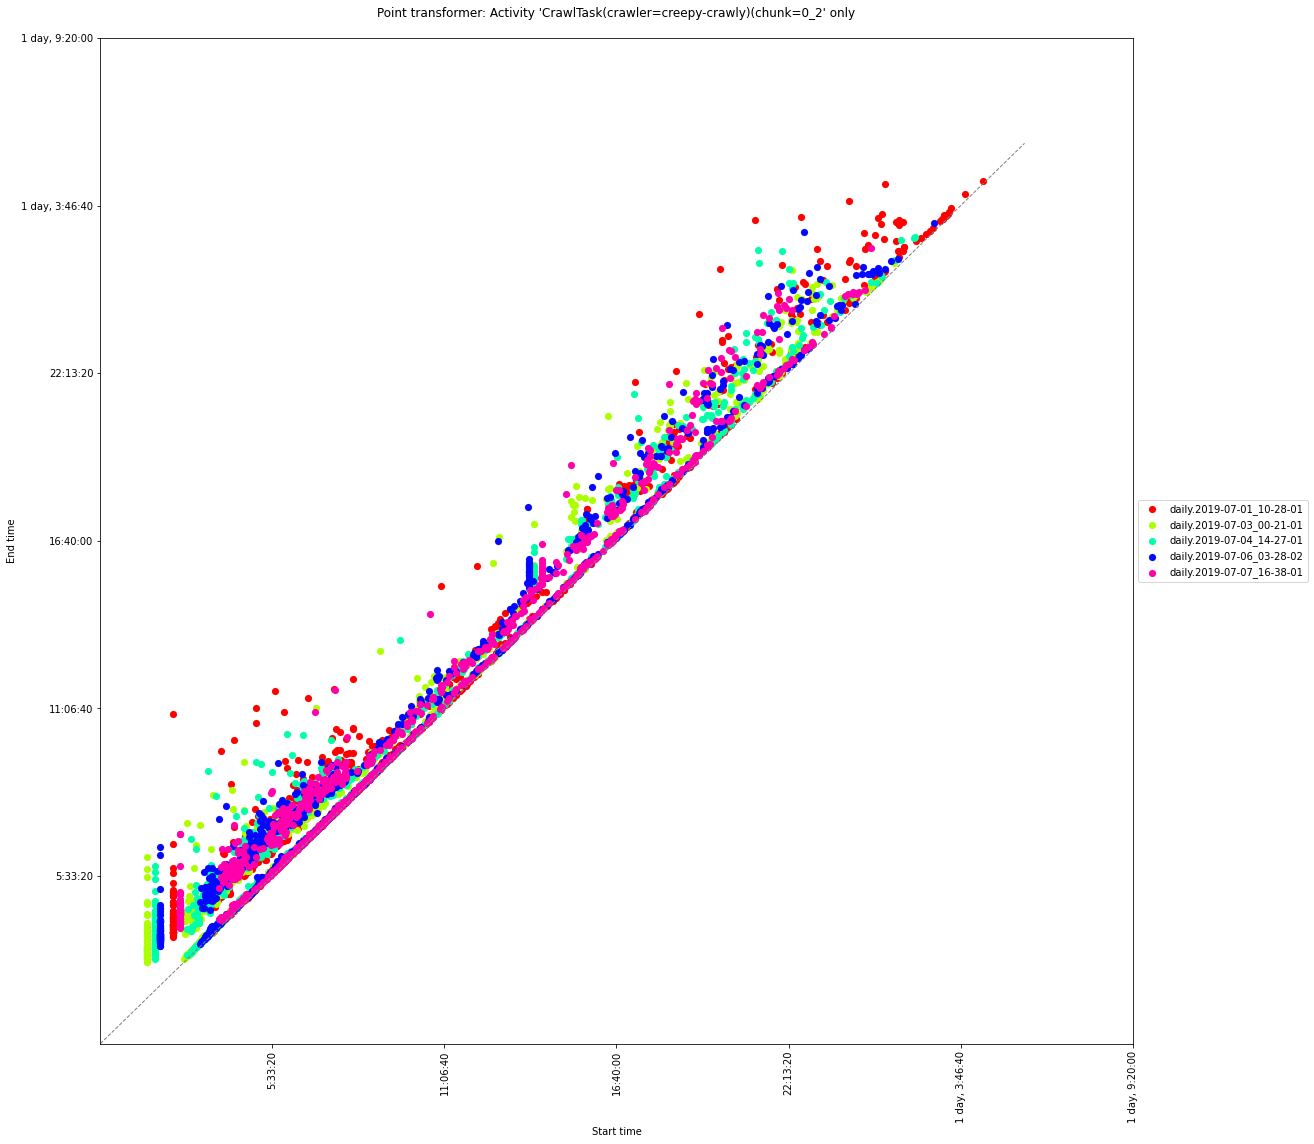

In [13]:
vis.plot_selected_activities(sample[sample['activity']=='CrawlTask(crawler=creepy-crawly)(chunk=0_2'], show_plot=1)

## Compute average trace
Average skyline contains a point per activity, depicting the average start and average end timestamps of it.

In [17]:
average_trace_activities = get_average_trace(get_relative_timestamps(excluding)).sort_values(by=['num_start'])
print('Average trace over activities has',len(average_trace_activities),'events')
average_trace_activities.head()
#print('AllTasks' in average_trace_activities)

Grouped: 6265 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 6745 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
Average trace over activities has 70 events


activity average_start  \
1                                   CrawlFeedTask_61      00:00:00   
3  DumpTask(sql_filename=reprocess_urls)(kvs=None...      00:00:12   
0                          DumpTask(sql_filename=_11      00:00:12   
5  DumpTask(sql_filename=mgmt_response)(kvs=None)...      00:01:50   
2                                  ProxySetupTask_16      00:06:25   

  average_end  num_start  num_end          case   std_num_end  
1    00:18:03        0.0   1083.6  Average Case  0.000000e+00  
3    00:00:55       12.2     55.2  Average Case  0.000000e+00  
0    00:11:14       12.4    674.2  Average Case  1.176771e-13  
5    01:27:38      110.4   5258.2  Average Case  0.000000e+00  
2    00:13:00      385.4    780.3  Average Case  0.000000e+00

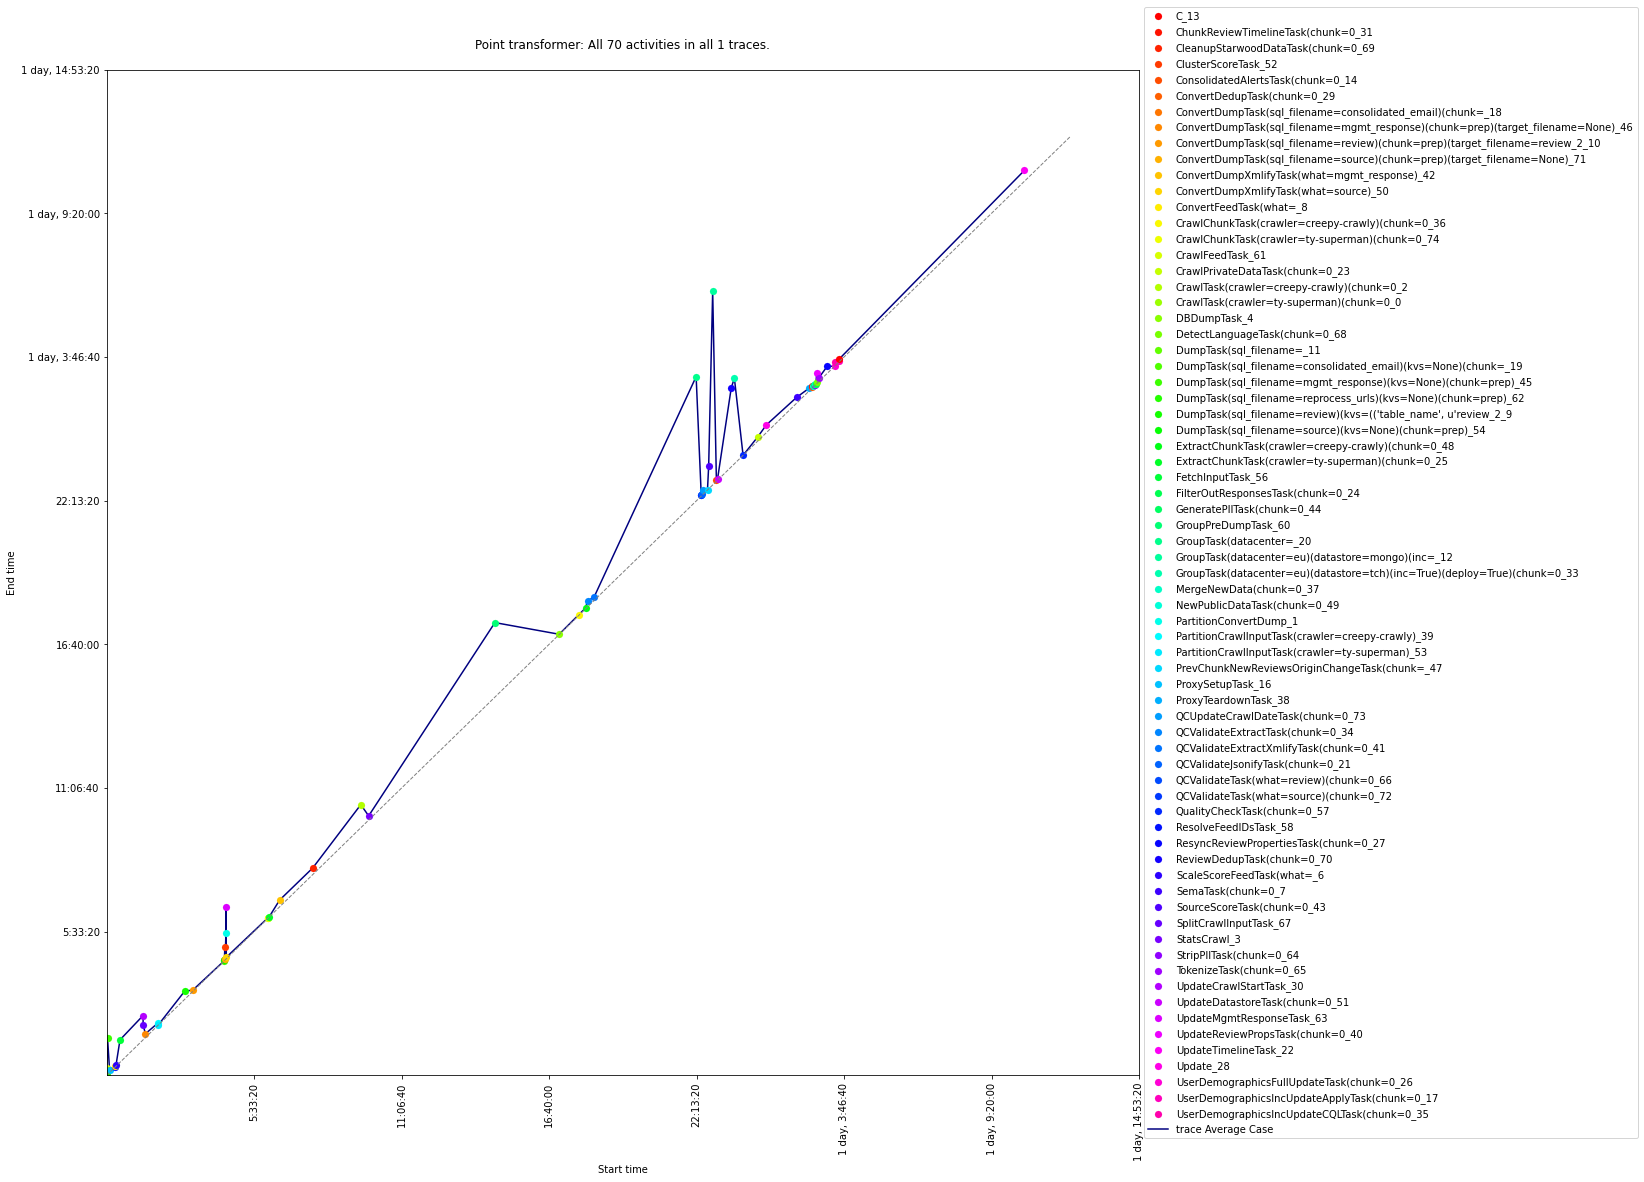

In [18]:
vis.plot_all_traces(average_trace_activities, show_plot=None)

In case only one subset of activities from the whole data set should be investigated

NOTE: This is specific to the 'daily.2019-0.csv' dataset

In [21]:
subset = excluding.copy() #Comment this out to only examine a certain snippet of the subset from above
subset.head()

case  \
0   daily.2019-07-01_10-28-01   
21  daily.2019-07-01_10-28-01   
22  daily.2019-07-01_10-28-01   
23  daily.2019-07-01_10-28-01   
24  daily.2019-07-01_10-28-01   

                                                          activity rel_start  \
0   DumpTask(sql_filename=_11                                       0:00:00    
21  CrawlFeedTask_61                                                0:00:00    
22  ProxySetupTask_16                                               0:00:00    
23  DumpTask(sql_filename=_11                                       0:00:00    
24  DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep)_62  0:00:00    

    rel_end  num_start  num_end           start_time             end_time  
0   0:04:52  0.0        292.0    2019-07-01 10:41:26  2019-07-01 10:46:18  
21  0:17:10  0.0        1030.0   2019-07-01 10:41:26  2019-07-01 10:58:36  
22  0:13:17  0.0        797.0    2019-07-01 10:41:26  2019-07-01 10:54:43  
23  1:02:58  0.0        3778.0   2019-07-01 10:41:26  2019-07-01 11:44:24  
24  0:01:43  0.0        103.0    2019-07-01 10:41:26  2019-07-01 10:43:09

## Compute Performance Skyline

In [22]:
skyline_points = get_skyline_points(subset)
representative = skyline_points[['case','activity']].drop_duplicates()

print(len(subset),' points in total distributed among', len(subset['case'].unique()), 'cases\n\nInfo about the skyline:')
print('- ',len(skyline_points),'/',len(subset),'=', round(len(skyline_points)/len(subset)*100,2), '% events are part of a skyline')
print('- ',len(skyline_points['activity'].unique()),'/',len(subset['activity'].unique()),'=', round(len(skyline_points['activity'].unique())/len(subset['activity'].unique())*100,2), 'activities are part of a skyline.')
print('- ',len(representative),'/',len(skyline_points),'=', round(len(representative)/len(skyline_points)*100,2), '% unique activities on the skylines.') 
print("   'Unique' meaning there are no two points with the same 'activity' on the skyline of the same trace. ")

skyline_points.head()

6265  points in total distributed among 5 cases

Info about the skyline:
-  229 / 6265 = 3.66 % events are part of a skyline
-  25 / 70 = 35.71 activities are part of a skyline.
-  82 / 229 = 35.81 % unique activities on the skylines.
   'Unique' meaning there are no two points with the same 'activity' on the skyline of the same trace. 


num_start  num_end  \
0  0.0        292.0     
1  0.0        1030.0    
2  0.0        1030.0    
3  0.0        3778.0    
4  0.0        3778.0    

                                                         activity  \
0  DumpTask(sql_filename=_11                                        
1  CrawlFeedTask_61                                                 
2  ProxySetupTask_16                                                
3  DumpTask(sql_filename=_11                                        
4  DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep)_62   

                        case  
0  daily.2019-07-01_10-28-01  
1  daily.2019-07-01_10-28-01  
2  daily.2019-07-01_10-28-01  
3  daily.2019-07-01_10-28-01  
4  daily.2019-07-01_10-28-01

## Stats by Case

In [22]:
all_by_case = subset.groupby('case').size().reset_index(name='total_points_in_case').sort_values(by=['total_points_in_case'], ascending=False)
skyline_by_case = skyline_points.groupby('case').size().reset_index(name='skyline_points_in_case').sort_values(by=['skyline_points_in_case'], ascending=False)
r_by_case = representative.groupby('case').size().reset_index(name='unique_skyline_activities_in_case').sort_values(by=['unique_skyline_activities_in_case'], ascending=False)
by_case = r_by_case.merge(skyline_by_case, on='case', how='inner')
#all_by_case.plot.hist(bins=8, alpha=0.5)

all_by_activity = subset.groupby('activity').size().reset_index(name='total_points_per_activity').sort_values(by=['total_points_per_activity'], ascending=False)
all_by_activity['total_points_per_activity']=all_by_activity.apply(lambda row: round(row['total_points_per_activity']/50), axis=1)

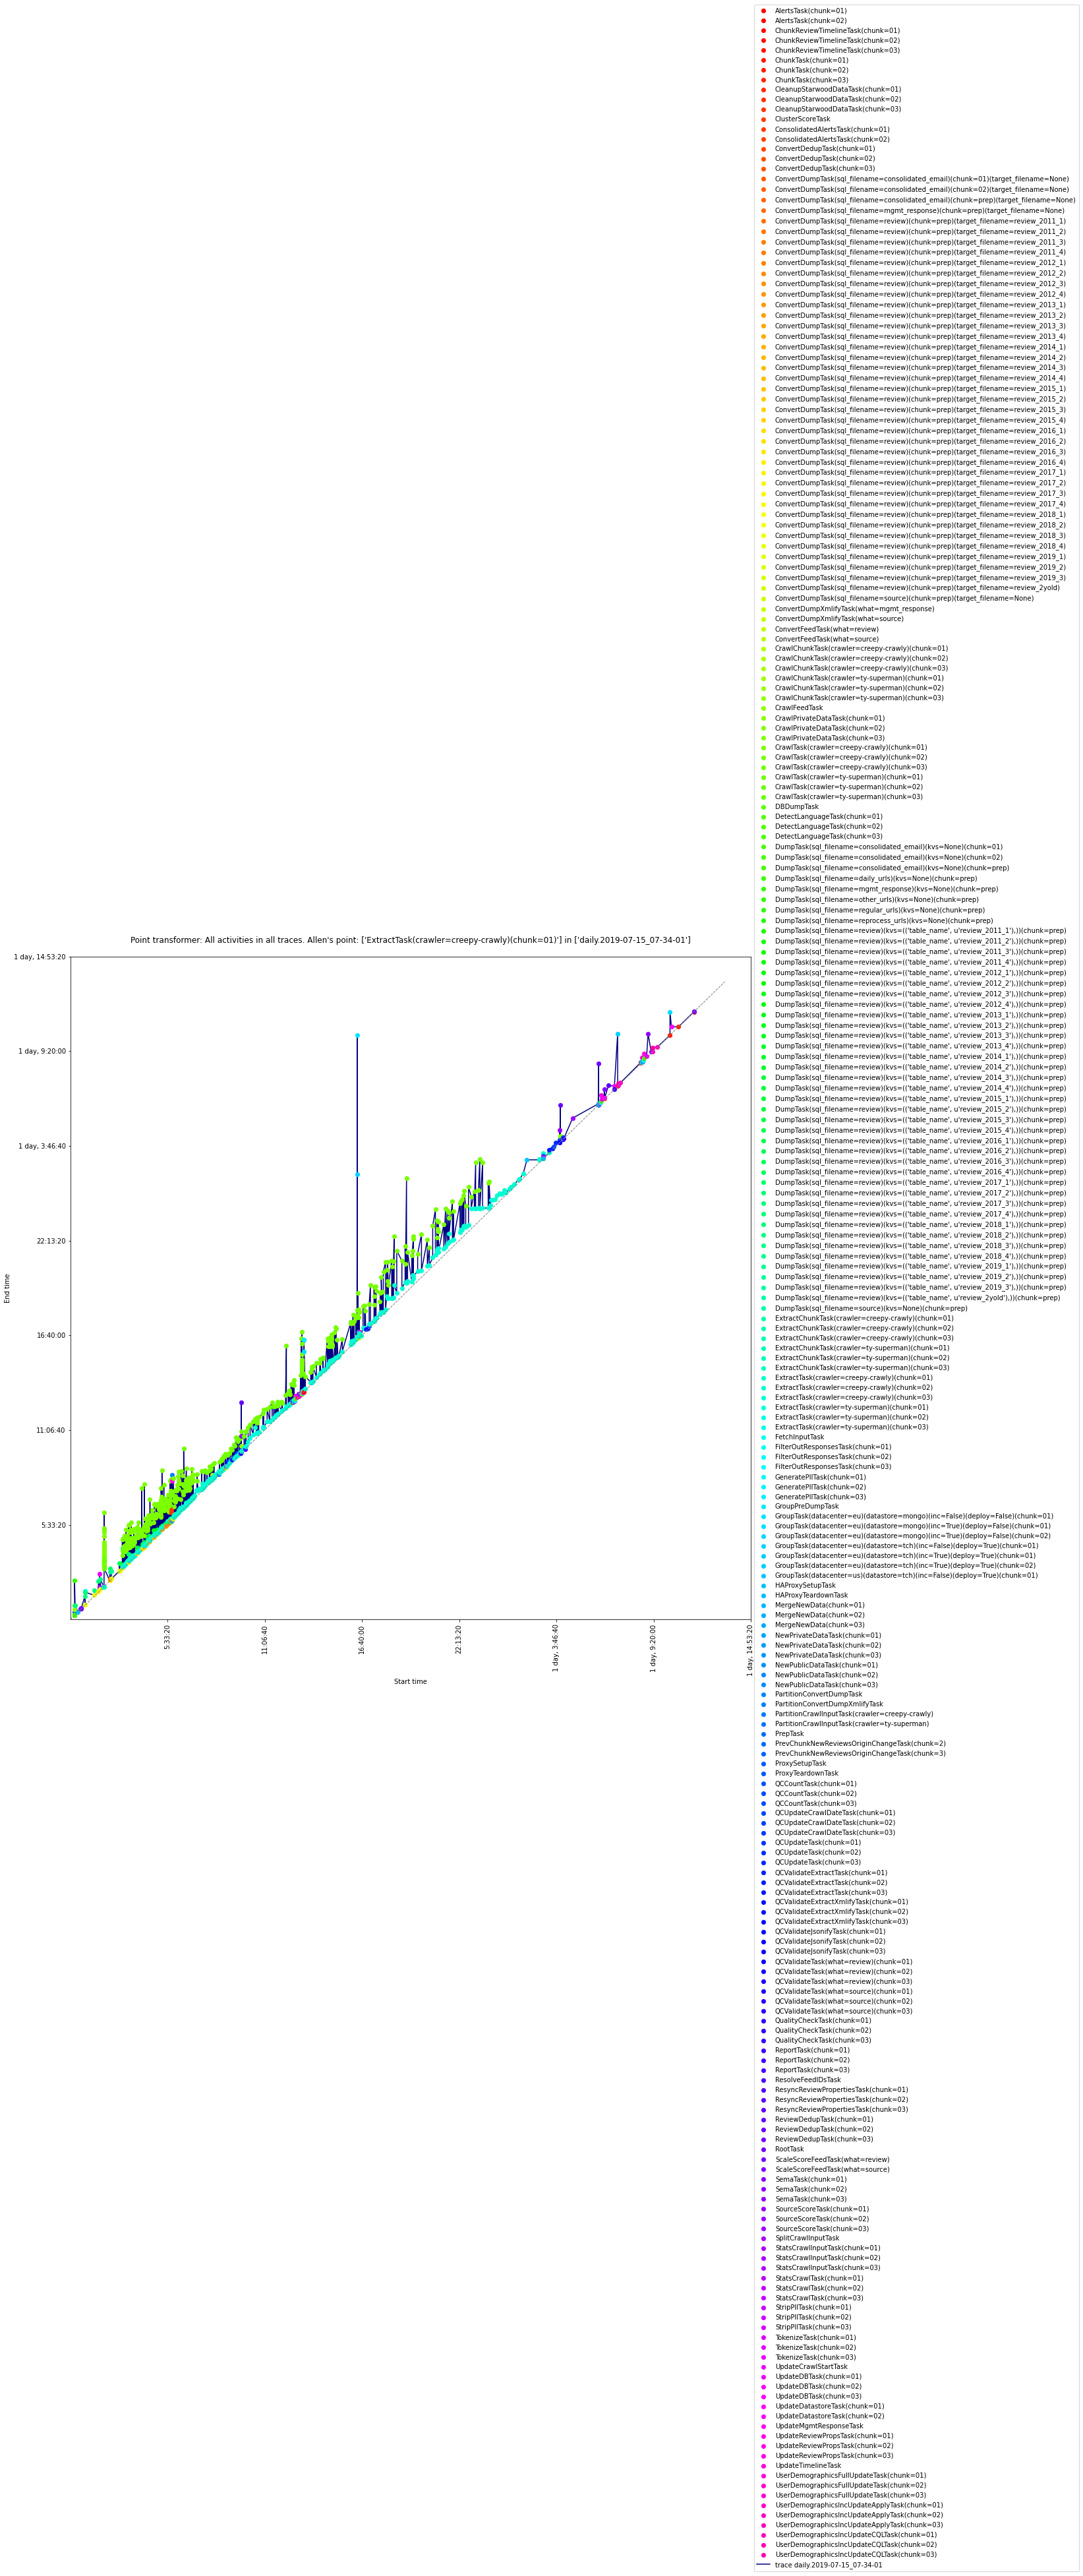

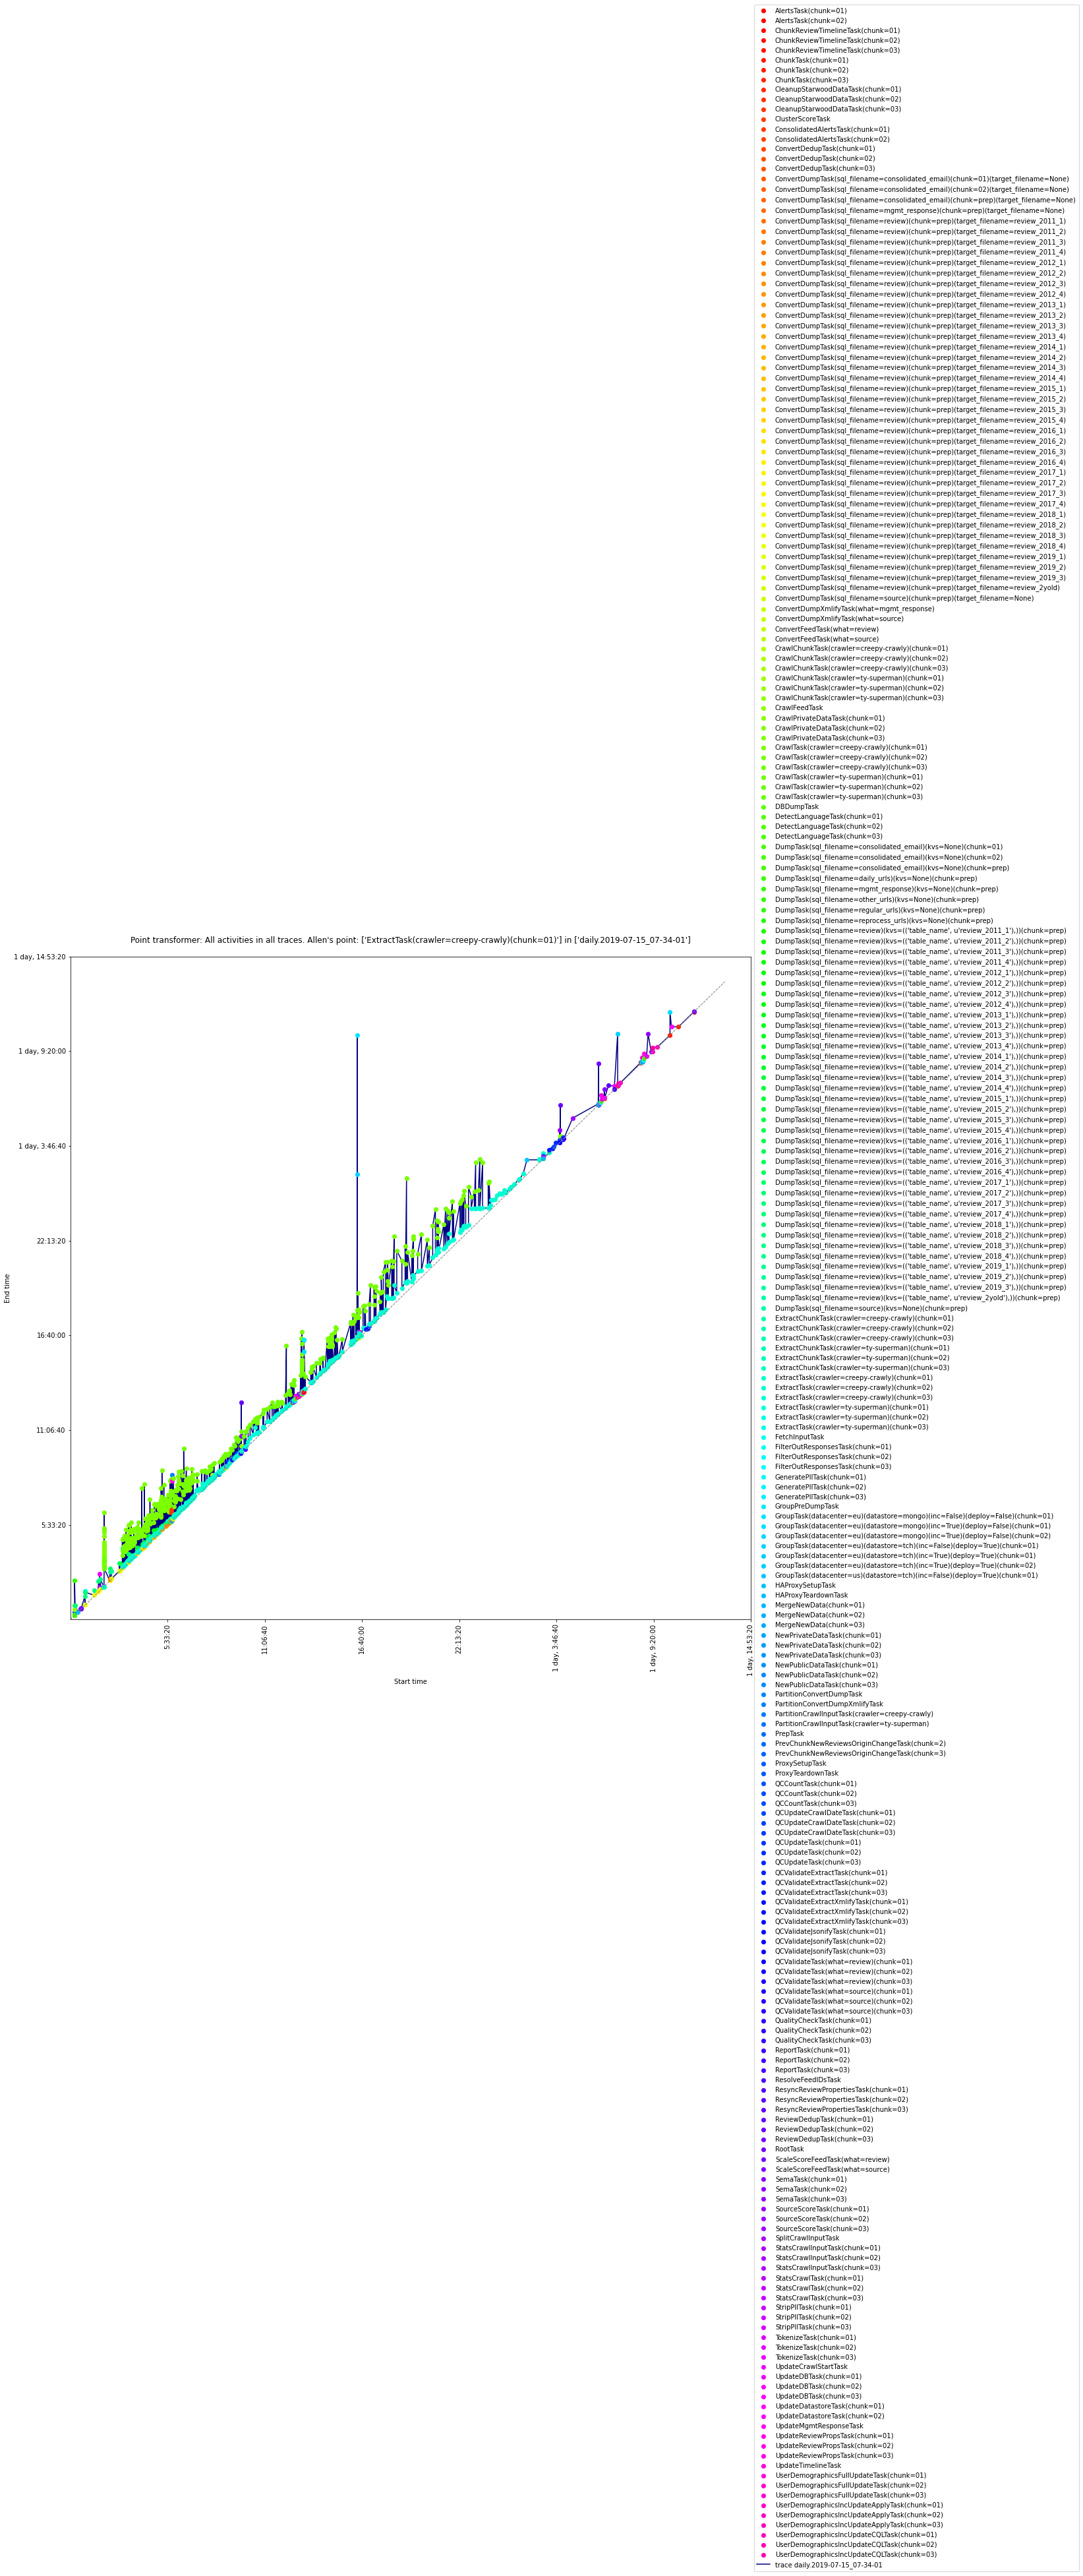

In [24]:
vis.plot_all_traces(subset[subset['case']==subset['case'].unique()[9]], show_plot=1)

In [25]:
merged_by_case = by_case.merge(all_by_case)[['case','total_points_in_case','skyline_points_in_case', 'unique_skyline_activities_in_case']].sort_values(by=['total_points_in_case'], ascending=False)
merged_by_case['skyline_percentage'] = merged_by_case.apply(lambda row: round(row['skyline_points_in_case']/row['total_points_in_case']*100,2), axis=1)
merged_by_case['unique_percentage'] = merged_by_case.apply(lambda row: round(row['unique_skyline_activities_in_case']/row['skyline_points_in_case']*100,2), axis=1)
print('Expectation/Averages: \ntotal_points_in_case:\t\t\t',round(merged_by_case['total_points_in_case'].mean(),2))
print('skyline_points_in_case:\t\t\t',round(merged_by_case['skyline_points_in_case'].mean(),2))
print('unique_skyline_activities_in_case:\t',round(merged_by_case['unique_skyline_activities_in_case'].mean(),2))
print('skyline_percentage:\t\t\t',round(merged_by_case['skyline_percentage'].mean(),2))
print('unique_percentage:\t\t\t',round(merged_by_case['unique_percentage'].mean(),2))
merged_by_case.head()

Expectation/Averages: 
total_points_in_case:			 1248.3
skyline_points_in_case:			 54.3
unique_skyline_activities_in_case:	 27.4
skyline_percentage:			 4.35
unique_percentage:			 51.33


case  total_points_in_case  skyline_points_in_case  \
4  daily.2019-07-13_21-50-01  1251                  61                       
2  daily.2019-07-07_16-38-01  1249                  62                       
3  daily.2019-07-12_08-18-01  1249                  55                       
9  daily.2019-07-06_03-28-02  1249                  64                       
0  daily.2019-07-04_14-27-01  1248                  59                       

   unique_skyline_activities_in_case  skyline_percentage  unique_percentage  
4  28                                 4.88                45.90              
2  31                                 4.96                50.00              
3  28                                 4.40                50.91              
9  20                                 5.12                31.25              
0  33                                 4.73                55.93